<a href="https://colab.research.google.com/github/Aniket21628/OCR/blob/main/OCR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q opencv-python numpy pandas scikit-learn tensorflow keras imutils

In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("sachinpatel21/az-handwritten-alphabets-in-csv-format")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/az-handwritten-alphabets-in-csv-format


In [5]:
import os
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
from keras.datasets import mnist
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.utils.class_weight import compute_class_weight

In [8]:
def process_kaggle_dataset():
    """Process Kaggle A-Z handwritten dataset (CSV format) - UPDATED"""
    df = pd.read_csv("/kaggle/input/az-handwritten-alphabets-in-csv-format/A_Z Handwritten Data.csv")
    data = []
    labels = []

    # Use iloc for positional access
    for i in range(len(df)):
        row = df.iloc[i]
        label = int(row.iloc[0])  # First column is label
        pixels = row.iloc[1:].values.astype("uint8")  # Remaining columns are pixels

        # Reshape to 28x28
        pixels = pixels.reshape((28, 28))
        data.append(pixels)
        labels.append(label + 10)  # Offset: A=10, B=11, ..., Z=35

    return np.array(data, dtype="float32"), np.array(labels, dtype="int")

In [7]:
def process_mnist():
    """Process MNIST dataset"""
    (train_data, train_labels), (test_data, test_labels) = mnist.load_data()
    mnist_data = np.vstack([train_data, test_data])
    mnist_labels = np.hstack([train_labels, test_labels])
    return mnist_data.astype("float32"), mnist_labels

In [6]:
!mkdir -p data/surrey

In [7]:
!wget -q http://www.ee.surrey.ac.uk/CVSSP/demos/chars74k/EnglishImg.tgz -O data/english.tgz
!tar -xf data/english.tgz -C data/surrey/

In [8]:
!tar -xzf data/english.tgz -C data/surrey/ --strip-components=1

In [9]:
import os

# Check if files exist
surrey_path = "data/surrey/English/Img/GoodImg/Bmp"
if os.path.exists(surrey_path):
    print(f"Found {len(os.listdir(surrey_path))} character folders")
    sample_folder = os.path.join(surrey_path, os.listdir(surrey_path)[0])
    print(f"Sample folder contains {len(os.listdir(sample_folder))} images")
else:
    print("Dataset not found. Manual download required.")
    print("Please download from: https://github.com/sachinpatel21/Chars74k_Dataset")

Found 62 character folders
Sample folder contains 36 images


In [6]:
def process_surrey_dataset():
    """Process University of Surrey dataset (image files)"""
    SURREY_PATH = "data/surrey/English/Img/GoodImg/Bmp"
    characters = "0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz"

    data = []
    labels = []

    # Sort folders numerically (Sample001, Sample002, etc)
    folders = sorted(
        [f for f in os.listdir(SURREY_PATH) if f.startswith("Sample")],
        key=lambda x: int(x[6:])
    )

    for idx, folder in enumerate(folders):
        char_path = os.path.join(SURREY_PATH, folder)
        if not os.path.isdir(char_path):
            continue

        for img_file in os.listdir(char_path):
            if img_file.startswith("."):
                continue

            img_path = os.path.join(char_path, img_file)
            img = cv2.imread(img_path)

            if img is None:
                continue

            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            resized = cv2.resize(gray, (28, 28))
            data.append(resized)
            labels.append(idx)  # Use folder index as label

    return np.array(data, dtype="float32"), np.array(labels, dtype="int")

In [9]:
print("Processing MNIST dataset...")
mnist_data, mnist_labels = process_mnist()

print("Processing Kaggle A-Z dataset...")
kaggle_data, kaggle_labels = process_kaggle_dataset()

print("Processing Surrey dataset...")
surrey_data, surrey_labels = process_surrey_dataset()

# Verify datasets
print(f"MNIST: {mnist_data.shape[0]} images")
print(f"Kaggle: {kaggle_data.shape[0]} images")
print(f"Surrey: {surrey_data.shape[0]} images")


Processing MNIST dataset...
Processing Kaggle A-Z dataset...
Processing Surrey dataset...
MNIST: 70000 images
Kaggle: 372450 images
Surrey: 7705 images


In [10]:
combined_data = np.vstack([mnist_data, kaggle_data, surrey_data])
combined_labels = np.hstack([mnist_labels, kaggle_labels, surrey_labels])

In [11]:
np.save("combined_data.npy", combined_data)
np.save("combined_labels.npy", combined_labels)
print(f"Combined dataset size: {combined_data.shape[0]} images")

Combined dataset size: 450155 images


In [6]:
# Load combined dataset
data = np.load("combined_data.npy")
labels = np.load("combined_labels.npy")

In [7]:
# Resize to 32x32 for ResNet
resized_data = np.array([cv2.resize(img, (32, 32)) for img in data])
resized_data = np.expand_dims(resized_data, axis=-1)  # Add channel dimension
resized_data = resized_data / 255.0  # Normalize

In [8]:
# Compute class weights to handle imbalance
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(labels),
    y=labels
)
class_weight_dict = {i: weight for i, weight in enumerate(class_weights)}

In [9]:
# One-hot encode labels
label_bin = LabelBinarizer()
bin_labels = label_bin.fit_transform(labels)

In [10]:
# Split into train/test sets
(trainX, testX, trainY, testY) = train_test_split(
    resized_data, bin_labels, test_size=0.25, random_state=42
)

print(f"Train shape: {trainX.shape}, Test shape: {testX.shape}")

Train shape: (337616, 32, 32, 1), Test shape: (112539, 32, 32, 1)


In [11]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Conv2D, BatchNormalization, Activation,
    Add, AveragePooling2D, Flatten, Dense, Dropout
)
from tensorflow.keras.regularizers import l2

In [12]:
def residual_module(x, num_filters, stride, reduce=False, reg=0.001):
    """ResNet residual module with regularization"""
    shortcut = x

    # Block 1: 1x1 conv
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Conv2D(int(num_filters * 0.25), (1, 1), use_bias=False,
              kernel_regularizer=l2(reg))(x)

    # Block 2: 3x3 conv
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Conv2D(int(num_filters * 0.25), (3, 3), strides=stride,
               padding="same", use_bias=False,
               kernel_regularizer=l2(reg))(x)

    # Block 3: 1x1 conv
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Conv2D(num_filters, (1, 1), use_bias=False,
              kernel_regularizer=l2(reg))(x)

    # Shortcut connection
    if reduce:
        shortcut = Conv2D(num_filters, (1, 1), strides=stride,
                         use_bias=False, kernel_regularizer=l2(reg))(shortcut)

    x = Add()([x, shortcut])
    return x

In [31]:
def build_resnet(input_shape=(32, 32, 1), num_classes=62, reg=0.001):
    """Build ResNet model for OCR with regularization and dropout"""
    inputs = Input(shape=input_shape)

    # Initial processing
    x = BatchNormalization()(inputs)

    # Stage 1
    x = residual_module(x, 64, (1, 1), reg=reg)
    x = Dropout(0.2)(x)

    # Stage 2 (reduce spatial size)
    x = residual_module(x, 128, (2, 2), reduce=True, reg=reg)
    x = Dropout(0.3)(x)

    # Stage 3 (reduce spatial size)
    x = residual_module(x, 256, (2, 2), reduce=True, reg=reg)
    x = Dropout(0.3)(x)

    # Final layers
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = AveragePooling2D((8, 8))(x)
    x = Flatten()(x)
    x = Dense(num_classes, activation="softmax",
             kernel_regularizer=l2(reg))(x)

    return Model(inputs, x)

# Create model
model = build_resnet(reg=0.001)
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 32, 32, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cast_3 (Cast)       │ (None, 32, 32, 1) │          0 │ input_layer_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32, 1) │          4 │ cast_3[0][0]      │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32, 1) │          4 │ batch_normalizat… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_10       │ (None, 32, 32, 1) │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_11 (Conv2D)  │ (None, 32, 32,    │         16 │ activation_10[0]… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │         64 │ conv2d_11[0][0]   │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_11       │ (None, 32, 32,    │          0 │ batch_normalizat… │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_12 (Conv2D)  │ (None, 32, 32,    │      2,304 │ activation_11[0]… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │         64 │ conv2d_12[0][0]   │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_12       │ (None, 32, 32,    │          0 │ batch_normalizat… │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_13 (Conv2D)  │ (None, 32, 32,    │      1,024 │ activation_12[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_3 (Add)         │ (None, 32, 32,    │          0 │ conv2d_13[0][0],  │
│                     │ 64)               │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 32, 32,    │          0 │ add_3[0][0]       │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        256 │ dropout_3[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_13       │ (None, 32, 32,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_14 (Conv2D)  │ (None, 32, 32,    │      2,048 │ activation_13[0]… │
│                     │ 32)               │            │                 

 Total params: 139,734 (545.84 KB)

 Trainable params: 138,386 (540.57 KB)

 Non-trainable params: 1,348 (5.27 KB)

In [32]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Compile model
model.compile(
    loss="categorical_crossentropy",
    optimizer=Adam(learning_rate=0.001),
    metrics=["accuracy"]
)

# Data augmentation
aug = ImageDataGenerator(
    rotation_range=8,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.15,
    zoom_range=0.1,
    fill_mode='nearest'
)

# Callbacks
checkpoint = ModelCheckpoint(
    "ocr_model.h5",
    save_best_only=True,
    monitor="val_accuracy",
    mode='max',
    verbose=1
)

early_stop = EarlyStopping(
    monitor="val_accuracy",
    patience=5,
    restore_best_weights=True,
    mode='max'
)

# Train
history = model.fit(
    aug.flow(trainX, trainY, batch_size=256),
    validation_data=(testX, testY),
    epochs=50,
    callbacks=[checkpoint, early_stop],
    class_weight=class_weight_dict
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
1319/1319 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 0.1170 - loss: 4.3317
Epoch 1: val_accuracy improved from -inf to 0.06191, saving model to ocr_model.h5


1319/1319 ━━━━━━━━━━━━━━━━━━━━ 180s 114ms/step - accuracy: 0.1170 - loss: 4.3313 - val_accuracy: 0.0619 - val_loss: 8.1880
Epoch 2/50
1319/1319 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.4697 - loss: 2.8986
Epoch 2: val_accuracy improved from 0.06191 to 0.28435, saving model to ocr_model.h5


1319/1319 ━━━━━━━━━━━━━━━━━━━━ 133s 101ms/step - accuracy: 0.4698 - loss: 2.8985 - val_accuracy: 0.2844 - val_loss: 2.9775
Epoch 3/50
1319/1319 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.7337 - loss: 2.3640
Epoch 3: val_accuracy improved from 0.28435 to 0.38061, saving model to ocr_model.h5


1319/1319 ━━━━━━━━━━━━━━━━━━━━ 120s 91ms/step - accuracy: 0.7338 - loss: 2.3639 - val_accuracy: 0.3806 - val_loss: 2.3579
Epoch 4/50
1319/1319 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.7786 - loss: 2.1209
Epoch 4: val_accuracy improved from 0.38061 to 0.69784, saving model to ocr_model.h5


1319/1319 ━━━━━━━━━━━━━━━━━━━━ 120s 91ms/step - accuracy: 0.7786 - loss: 2.1209 - val_accuracy: 0.6978 - val_loss: 1.3221
Epoch 5/50
1319/1319 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.7908 - loss: 1.9681
Epoch 5: val_accuracy did not improve from 0.69784
1319/1319 ━━━━━━━━━━━━━━━━━━━━ 125s 94ms/step - accuracy: 0.7908 - loss: 1.9681 - val_accuracy: 0.6874 - val_loss: 1.3911
Epoch 6/50
1319/1319 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.7939 - loss: 1.8426
Epoch 6: val_accuracy did not improve from 0.69784
1319/1319 ━━━━━━━━━━━━━━━━━━━━ 121s 91ms/step - accuracy: 0.7939 - loss: 1.8426 - val_accuracy: 0.5748 - val_loss: 1.7337
Epoch 7/50
1319/1319 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.7964 - loss: 1.8086
Epoch 7: val_accuracy improved from 0.69784 to 0.72049, saving model to ocr_model.h5


1319/1319 ━━━━━━━━━━━━━━━━━━━━ 121s 91ms/step - accuracy: 0.7964 - loss: 1.8086 - val_accuracy: 0.7205 - val_loss: 1.2714
Epoch 8/50
1319/1319 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 0.7965 - loss: 1.7159
Epoch 8: val_accuracy did not improve from 0.72049
1319/1319 ━━━━━━━━━━━━━━━━━━━━ 119s 90ms/step - accuracy: 0.7965 - loss: 1.7159 - val_accuracy: 0.6938 - val_loss: 1.4438
Epoch 9/50
1319/1319 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.8012 - loss: 1.6305
Epoch 9: val_accuracy improved from 0.72049 to 0.74497, saving model to ocr_model.h5


1319/1319 ━━━━━━━━━━━━━━━━━━━━ 130s 99ms/step - accuracy: 0.8012 - loss: 1.6305 - val_accuracy: 0.7450 - val_loss: 1.2631
Epoch 10/50
1319/1319 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 0.8068 - loss: 1.5366
Epoch 10: val_accuracy improved from 0.74497 to 0.80599, saving model to ocr_model.h5


1319/1319 ━━━━━━━━━━━━━━━━━━━━ 119s 90ms/step - accuracy: 0.8068 - loss: 1.5367 - val_accuracy: 0.8060 - val_loss: 1.0775
Epoch 11/50
1319/1319 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.8019 - loss: 1.5962
Epoch 11: val_accuracy did not improve from 0.80599
1319/1319 ━━━━━━━━━━━━━━━━━━━━ 130s 98ms/step - accuracy: 0.8019 - loss: 1.5962 - val_accuracy: 0.7141 - val_loss: 1.4450
Epoch 12/50
1319/1319 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 0.8058 - loss: 1.5462
Epoch 12: val_accuracy improved from 0.80599 to 0.83612, saving model to ocr_model.h5


1319/1319 ━━━━━━━━━━━━━━━━━━━━ 119s 90ms/step - accuracy: 0.8058 - loss: 1.5462 - val_accuracy: 0.8361 - val_loss: 1.0800
Epoch 13/50
1319/1319 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.8062 - loss: 1.5203
Epoch 13: val_accuracy did not improve from 0.83612
1319/1319 ━━━━━━━━━━━━━━━━━━━━ 142s 90ms/step - accuracy: 0.8062 - loss: 1.5203 - val_accuracy: 0.8245 - val_loss: 1.1405
Epoch 14/50
1319/1319 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.8115 - loss: 1.4797
Epoch 14: val_accuracy did not improve from 0.83612
1319/1319 ━━━━━━━━━━━━━━━━━━━━ 120s 91ms/step - accuracy: 0.8115 - loss: 1.4797 - val_accuracy: 0.7571 - val_loss: 1.2793
Epoch 15/50
1319/1319 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 0.8061 - loss: 1.5412
Epoch 15: val_accuracy did not improve from 0.83612
1319/1319 ━━━━━━━━━━━━━━━━━━━━ 141s 90ms/step - accuracy: 0.8061 - loss: 1.5411 - val_accuracy: 0.7276 - val_loss: 1.2923
Epoch 16/50
1319/1319 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.8123 - loss: 1.4

In [33]:
from sklearn.metrics import classification_report

# Load best model
model.load_weights("ocr_model.h5")

# Predictions
preds = model.predict(testX, batch_size=256)
pred_labels = np.argmax(preds, axis=1)
true_labels = np.argmax(testY, axis=1)

# Classification report
characters = "0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz"
print(classification_report(
    true_labels, pred_labels,
    target_names=list(characters),
    zero_division=0
))

440/440 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step
              precision    recall  f1-score   support

           0       0.23      0.40      0.29      1692
           1       0.96      0.92      0.94      1936
           2       0.70      0.84      0.77      1815
           3       0.86      0.93      0.90      1808
           4       0.83      0.67      0.75      1713
           5       0.75      0.39      0.51      1597
           6       0.95      0.75      0.84      1725
           7       0.70      0.92      0.79      1845
           8       0.98      0.63      0.77      1720
           9       0.97      0.79      0.87      1782
           A       0.95      0.80      0.87      3681
           B       0.91      0.76      0.83      2215
           C       0.89      0.91      0.90      5816
           D       0.72      0.89      0.80      2531
           E       1.00      0.75      0.86      2957
           F       0.64      0.90      0.75       287
           G       0.53      0.91      

In [34]:
import imutils
from imutils.contours import sort_contours

def adaptive_thresholding(image):
    """Improved adaptive thresholding for license plates"""
    # Apply adaptive thresholding
    thresh = cv2.adaptiveThreshold(
        image, 255,
        cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
        cv2.THRESH_BINARY_INV, 11, 5
    )

    # Apply morphological operations to clean up
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 2))
    cleaned = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel)
    return cleaned

def better_resize(char_img, target_size=32):
    """Maintain aspect ratio without distortion"""
    h, w = char_img.shape
    scale = target_size / max(h, w)
    new_h, new_w = int(h * scale), int(w * scale)
    resized = cv2.resize(char_img, (new_w, new_h))

    # Center in target size
    canvas = np.zeros((target_size, target_size), dtype=np.uint8)
    y_offset = (target_size - new_h) // 2
    x_offset = (target_size - new_w) // 2
    canvas[y_offset:y_offset+new_h, x_offset:x_offset+new_w] = resized
    return canvas

def predict_license_plate(image_path, model, confidence_threshold=0.7):
    """Enhanced license plate text prediction"""
    # Load and preprocess image
    image = cv2.imread(image_path)
    if image is None:
        raise ValueError(f"Could not read image at {image_path}")

    # Convert to grayscale and enhance contrast
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.equalizeHist(gray)

    # Noise reduction and edge detection
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    edged = cv2.Canny(blurred, 50, 200)

    # Find contours
    cnts = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = cnts[0] if len(cnts) == 2 else cnts[1]

    # Sort contours from left to right
    cnts, _ = sort_contours(cnts, method="left-to-right")

    chars = []
    for c in cnts:
        # Get bounding box
        (x, y, w, h) = cv2.boundingRect(c)

        # Filter plausible character regions
        aspect_ratio = w / float(h)
        if not (0.2 < aspect_ratio < 1.5 and 20 < h < 120 and w > 10):
            continue

        # Extract ROI
        roi = gray[y:y+h, x:x+w]

        # Apply adaptive thresholding
        thresh = adaptive_thresholding(roi)

        # Resize while maintaining aspect ratio
        resized = better_resize(thresh, 32)

        # Prepare for model
        char_img = resized.astype("float32") / 255.0
        char_img = np.expand_dims(char_img, axis=-1)
        chars.append((char_img, (x, y, w, h)))

    # Predict characters
    if not chars:
        return ""

    char_images = np.array([c[0] for c in chars])
    preds = model.predict(char_images)

    # Generate output with confidence thresholding
    characters = "0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz"
    uppercase_chars = "0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ"
    output = ""

    for pred in preds:
        idx = np.argmax(pred)
        confidence = np.max(pred)
        char = characters[idx]

        # Handle case sensitivity
        if char.islower() and confidence < confidence_threshold:
            # Find uppercase equivalent
            upper_char = char.upper()
            if upper_char in uppercase_chars:
                char = upper_char

        output += char

    return output

Test image downloaded successfully
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Predicted License Plate: BQQQBQQBQQQQB


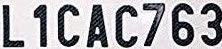

In [35]:
import requests
from PIL import Image
from IPython.display import display, Image as IPImage

# Download a test license plate image
TEST_IMAGE_URL = "https://raw.githubusercontent.com/nik-hil-29/ocr/main/contents/test1.jpeg"
try:
    response = requests.get(TEST_IMAGE_URL, stream=True)
    response.raise_for_status()
    with open("test_plate.jpg", "wb") as f:
        for chunk in response.iter_content(1024):
            f.write(chunk)
    print("Test image downloaded successfully")
except:
    print("Using fallback test image")
    !wget -q https://i.ibb.co/3yJ8QY5/license-plate-example.jpg -O test_plate.jpg

# Run prediction
try:
    plate_text = predict_license_plate("test_plate.jpg", model)
    print(f"Predicted License Plate: {plate_text}")

    # Display the test image
    display(IPImage(filename='test_plate.jpg', width=400))
except Exception as e:
    print(f"Prediction failed: {str(e)}")

In [ ]:
# Save final model in modern Keras format
model.save("final_ocr_model.keras", save_format="keras")
print("Model saved as final_ocr_model.keras")

# Save label binarizer
import joblib
joblib.dump(label_bin, "label_binarizer.pkl")